# Etapa 1 — Introdução ao Projeto

O objetivo deste projeto é desenvolver e implantar um **modelo de Inteligência Artificial (IA)** capaz de **prever o valor de aluguel de imóveis no Brasil**, utilizando dados públicos reais.

A proposta segue os princípios estudados nas disciplinas de **Inteligência Artificial e Aprendizado de Máquina**, aplicando conceitos de:
- Manipulação e análise de dados (Pandas, NumPy);
- Visualização de dados (Matplotlib, Seaborn);
- Aprendizado supervisionado (Scikit-Learn);
- Avaliação de desempenho de modelos;
- Implantação simulada de um modelo via API.

O resultado final é um **modelo de regressão treinado com dados brasileiros**, capaz de estimar o valor de aluguel com base em características como área, número de quartos, cidade, taxa de condomínio, entre outros fatores.


In [2]:
!pip install fastapi pydantic uvicorn joblib


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


# Etapa 2 — Importação e Carregamento dos Dados

Nesta etapa realizamos o **carregamento do dataset** que contém informações sobre imóveis para aluguel em diversas cidades do Brasil.

O dataset utilizado é o **“Updated Brasilian Housing to Rent”**, que inclui colunas como:
- `city` — cidade do imóvel;
- `area` — metragem quadrada;
- `rooms`, `bathroom`, `parking_spaces` — número de cômodos;
- `hoa`, `rent_amount`, `property_tax`, `fire_insurance`, `total` — valores monetários.

Após o carregamento, fazemos uma **verificação inicial** dos dados para compreender o tamanho, estrutura e primeiras amostras do conjunto.


In [4]:
import pandas as pd

df = pd.read_csv("updated_brasilian_housing_to_rent.csv")
df.head()

,id,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,0,1,1,0,8000,1000,121,9121
1,1,0,64,2,1,1,10,1,0,540,820,122,11,1493
2,2,1,443,5,5,4,3,1,1,4172,7000,1417,89,12680
3,3,1,73,2,2,1,12,1,0,700,1250,150,16,2116
4,4,1,19,1,1,0,0,0,0,0,1200,41,16,1257


# Etapa 3 — Limpeza e Preparação dos Dados

Nesta etapa, realizamos a **limpeza e padronização dos dados** para que possam ser utilizados corretamente pelo modelo de Machine Learning.

As principais ações foram:
- Padronizar os nomes das colunas (minúsculas e sem espaços);
- Remover símbolos monetários (`R$`, vírgulas e espaços);
- Converter colunas de valores para o tipo `float`;
- Garantir consistência entre tipos de dados numéricos e categóricos.

Esse pré-processamento garante que os valores estejam prontos para análise estatística e para o treinamento do modelo de regressão.


In [6]:
df.info()
print("\nValores ausentes:")
print(df.isna().sum())

print("\nEstatísticas gerais:")
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              6080 non-null   int64
 1   city            6080 non-null   int64
 2   area            6080 non-null   int64
 3   rooms           6080 non-null   int64
 4   bathroom        6080 non-null   int64
 5   parking spaces  6080 non-null   int64
 6   floor           6080 non-null   int64
 7   animal          6080 non-null   int64
 8   furniture       6080 non-null   int64
 9   hoa             6080 non-null   int64
 10  rent amount     6080 non-null   int64
 11  property tax    6080 non-null   int64
 12  fire insurance  6080 non-null   int64
 13  total           6080 non-null   int64
dtypes: int64(14)
memory usage: 665.1 KB

Valores ausentes:
id                0
city              0
area              0
rooms             0
bathroom          0
parking spaces    0
floor             0
anima

In [7]:
df.columns.tolist()


['id',
 'city',
 'area',
 'rooms',
 'bathroom',
 'parking spaces',
 'floor',
 'animal',
 'furniture',
 'hoa',
 'rent amount',
 'property tax',
 'fire insurance',
 'total']

In [8]:
# Normaliza nomes de colunas
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"\(r\$\)", "", regex=True)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
)

# Agora as colunas devem ter nomes como: ['hoa', 'rent_amount', 'property_tax', 'fire_insurance', 'total']

# Verifique os nomes
print(df.columns.tolist())

# Identifique colunas de valores monetários
cols_valor = ['hoa', 'rent_amount', 'property_tax', 'fire_insurance', 'total']

# Remove "R$" e espaços e converte para float
for c in cols_valor:
    df[c] = df[c].astype(str).replace(r'[R$\s,]', '', regex=True).astype(float)

df.head()


['id', 'city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax', 'fire_insurance', 'total']


,id,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,0,1,240,3,3,4,0,1,1,0.0,8000.0,1000.0,121.0,9121.0
1,1,0,64,2,1,1,10,1,0,540.0,820.0,122.0,11.0,1493.0
2,2,1,443,5,5,4,3,1,1,4172.0,7000.0,1417.0,89.0,12680.0
3,3,1,73,2,2,1,12,1,0,700.0,1250.0,150.0,16.0,2116.0
4,4,1,19,1,1,0,0,0,0,0.0,1200.0,41.0,16.0,1257.0


# Etapa 4 — Análise Exploratória dos Dados (EDA)

Nesta etapa foi realizada a **Análise Exploratória de Dados (EDA)** para compreender o comportamento e a distribuição das variáveis.

Foram gerados:
- Histogramas para distribuição do valor de aluguel (`rent_amount`);
- Gráficos de dispersão entre área e valor de aluguel;
- Mapa de calor (heatmap) de correlação entre variáveis numéricas;
- Gráfico de barras mostrando o aluguel médio por cidade.

Essa análise permitiu identificar padrões, relações entre atributos e possíveis outliers, auxiliando na escolha do modelo de aprendizado mais adequado.


🔍 Valores nulos por coluna:
id                0
city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

Dimensões do dataset: (6080, 14)

📈 Estatísticas descritivas:


,id,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
count,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00,6080.00
mean,3039.50,0.86,151.14,2.49,2.34,1.76,5.67,0.77,0.26,1088.43,4395.84,490.33,58.20,6033.19
std,1755.29,0.34,375.56,1.13,1.44,1.61,6.17,0.42,0.44,3981.36,3576.67,6212.56,49.31,8751.35
min,0.00,0.00,10.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,420.00,0.00,3.00,660.00
25%,1519.75,1.00,58.00,2.00,1.00,1.00,0.00,1.00,0.00,24.50,1800.00,33.00,23.00,2451.50
50%,3039.50,1.00,100.00,3.00,2.00,1.00,4.00,1.00,0.00,650.00,3111.00,145.00,41.00,4128.50
75%,4559.25,1.00,200.00,3.00,3.00,2.00,9.00,1.00,1.00,1436.00,5952.50,458.00,77.00,8074.00
max,6079.00,1.00,24606.00,10.00,10.00,12.00,99.00,1.00,1.00,220000.00,45000.00,366300.00,677.00,372700.00


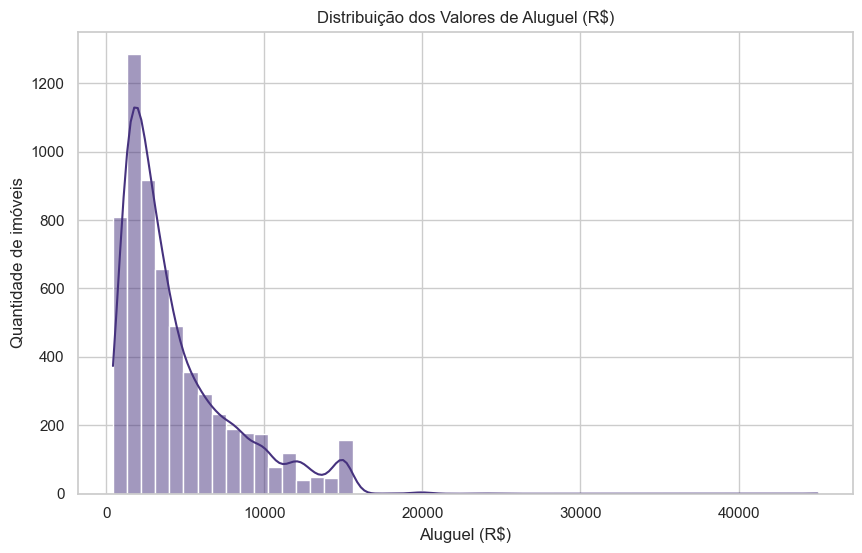

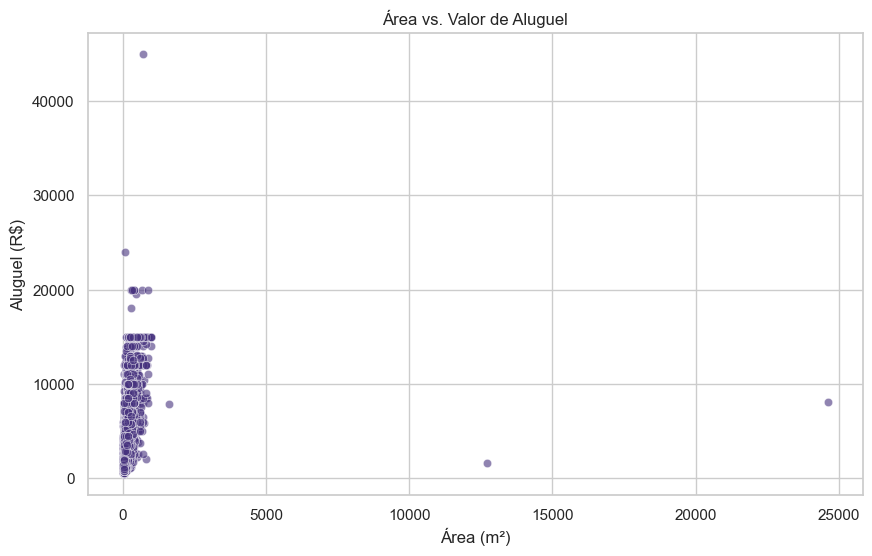

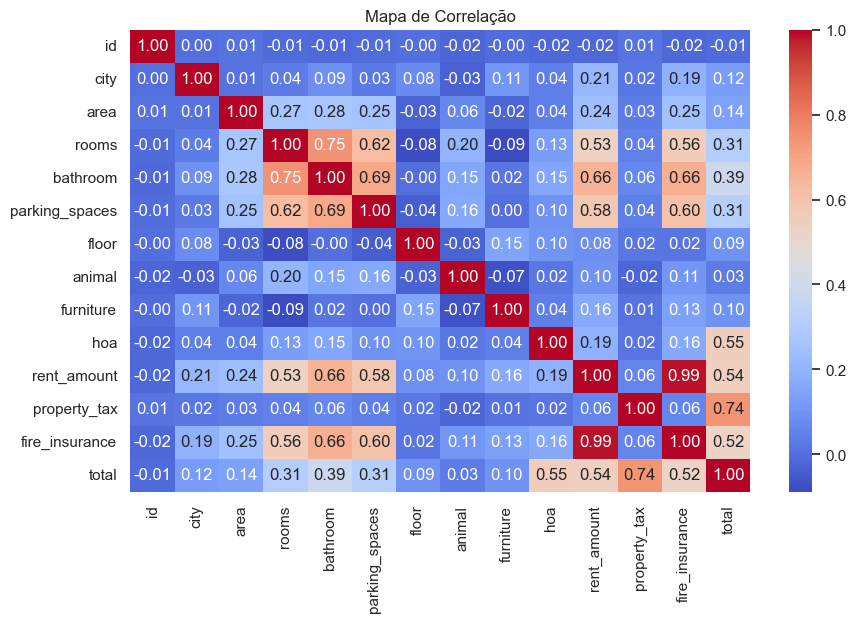

C:\Users\marce\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


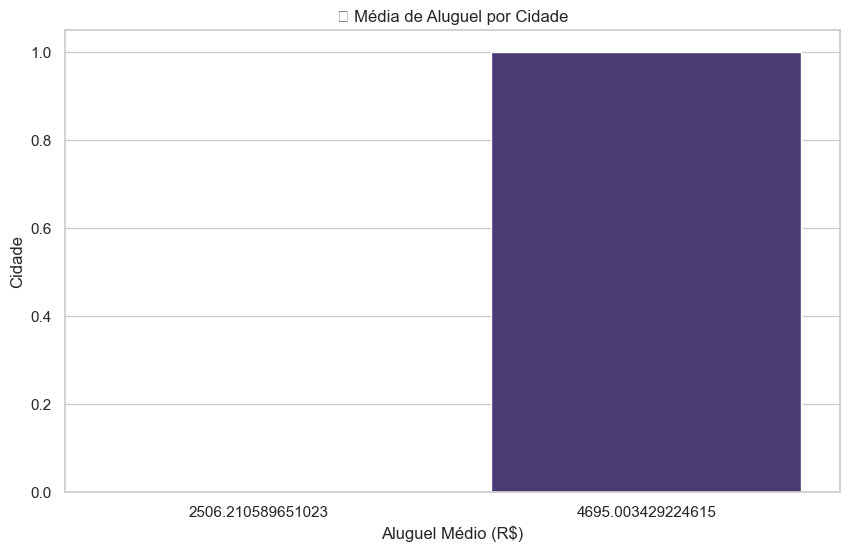

In [9]:
# ==========================================
# ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)

# 1️ — Verifica valores nulos
print("🔍 Valores nulos por coluna:")
print(df.isnull().sum())
print("\nDimensões do dataset:", df.shape)

# 2️ — Estatísticas descritivas
print("\n📈 Estatísticas descritivas:")
display(df.describe().round(2))

# 3️ — Distribuição dos preços de aluguel
plt.figure()
sns.histplot(df["rent_amount"], bins=50, kde=True)
plt.title("Distribuição dos Valores de Aluguel (R$)")
plt.xlabel("Aluguel (R$)")
plt.ylabel("Quantidade de imóveis")
plt.show()

# 4️ — Relação entre área e valor do aluguel
plt.figure()
sns.scatterplot(x="area", y="rent_amount", data=df, alpha=0.6)
plt.title("Área vs. Valor de Aluguel")
plt.xlabel("Área (m²)")
plt.ylabel("Aluguel (R$)")
plt.show()

# 5️ — Correlação entre variáveis numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação")
plt.show()

# 6️ — Análise por cidade (média de aluguel)
plt.figure()
media_cidade = df.groupby("city")["rent_amount"].mean().sort_values(ascending=False)
sns.barplot(x=media_cidade.values, y=media_cidade.index)
plt.title("💰 Média de Aluguel por Cidade")
plt.xlabel("Aluguel Médio (R$)")
plt.ylabel("Cidade")
plt.show()


# Etapa 5 — Pré-processamento e Treinamento do Modelo

Com os dados prontos, aplicamos técnicas de **aprendizado supervisionado** para treinar um modelo de **regressão** capaz de prever o valor do aluguel.

As etapas realizadas foram:
1. Seleção das variáveis de entrada (features) e da variável-alvo (`rent_amount`);
2. Codificação das variáveis categóricas com `LabelEncoder`;
3. Divisão do conjunto de dados em treino (80%) e teste (20%);
4. Treinamento do modelo **Random Forest Regressor**;
5. Avaliação com as métricas:
   - **MAE (Erro Absoluto Médio)**  
   - **MSE (Erro Quadrático Médio)**  
   - **R² (Coeficiente de Determinação)**

O modelo **Random Forest** foi escolhido por sua robustez, capacidade de capturar relações não lineares e excelente desempenho em dados tabulares.


📊 Resultados do Modelo de Regressão (Random Forest)
MAE (Erro Absoluto Médio): 101.85
MSE (Erro Quadrático Médio): 191,675.16
R² (Coeficiente de Determinação): 0.9836


C:\Users\marce\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


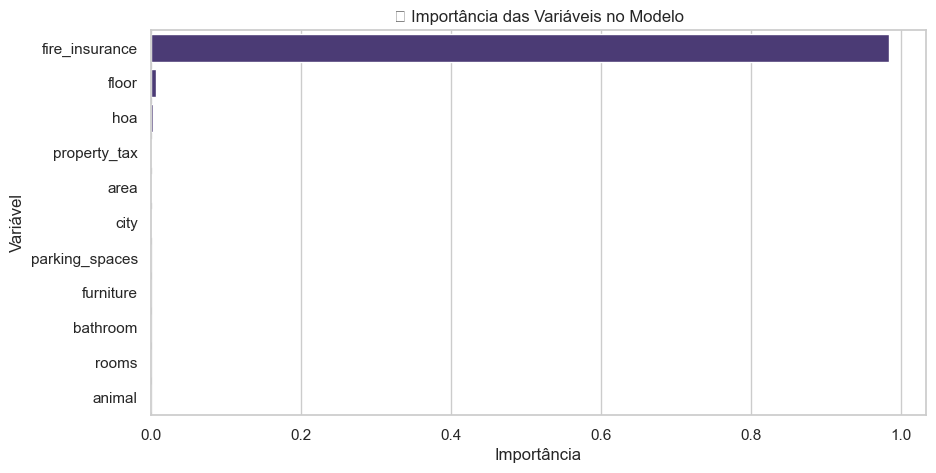

In [ ]:
# ==========================================
# PRÉ-PROCESSAMENTO E TREINAMENTO DO MODELO
# ==========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1️ — Seleciona features (X) e target (y)
X = df.drop(columns=["id", "rent_amount", "total"])
y = df["rent_amount"]

# 2️ — Codifica variáveis categóricas
cat_cols = X.select_dtypes(include=["object"]).columns

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# 3️ — Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️ — Cria e treina o modelo
modelo = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
modelo.fit(X_train, y_train)

# 5️ — Avaliação do modelo
y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados do Modelo de Regressão (Random Forest)")
print(f"MAE (Erro Absoluto Médio): {mae:,.2f}")
print(f"MSE (Erro Quadrático Médio): {mse:,.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# 6️ — Importância das variáveis
importances = modelo.feature_importances_
features = X.columns
import pandas as pd

df_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data=df_importance)
plt.title("Importância das Variáveis no Modelo")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()


# Etapa 6 — Avaliação do Modelo

Após o treinamento, avaliamos o desempenho do modelo com base nas métricas de regressão:

- **MAE (Mean Absolute Error):** indica o erro médio em reais;
- **MSE (Mean Squared Error):** penaliza erros grandes de forma mais severa;
- **R² (Coeficiente de Determinação):** mostra o quanto o modelo explica da variação dos preços.

Também foi gerado um gráfico de **importância das variáveis**, revelando quais fatores mais influenciam o preço de aluguel (geralmente: cidade, área, número de quartos e taxa de condomínio).


AVALIAÇÃO DO MODELO DE REGRESSÃO
MAE (Erro Absoluto Médio): 101.85
MSE (Erro Quadrático Médio): 191675.16
R² (Coeficiente de Determinação): 0.9836


C:\Users\marce\AppData\Local\Temp\ipykernel_26132\2015393358.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


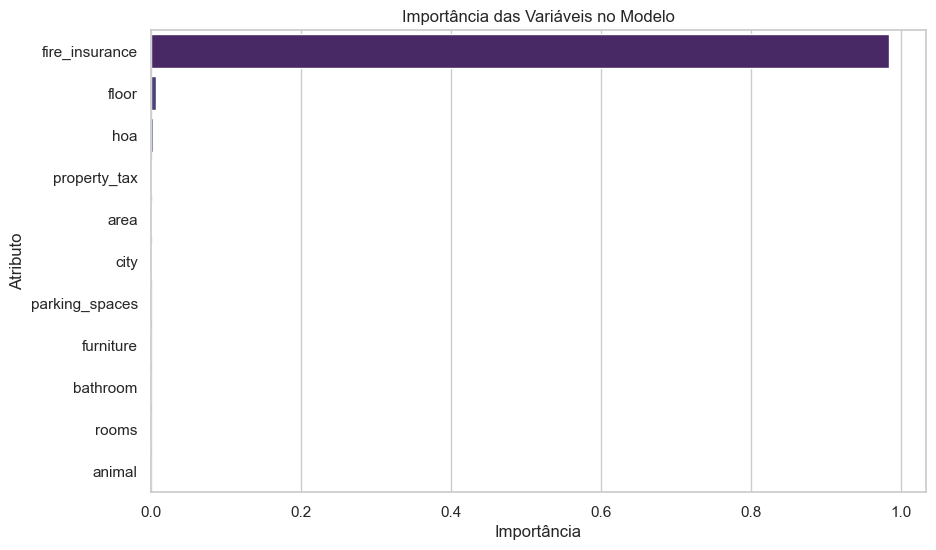

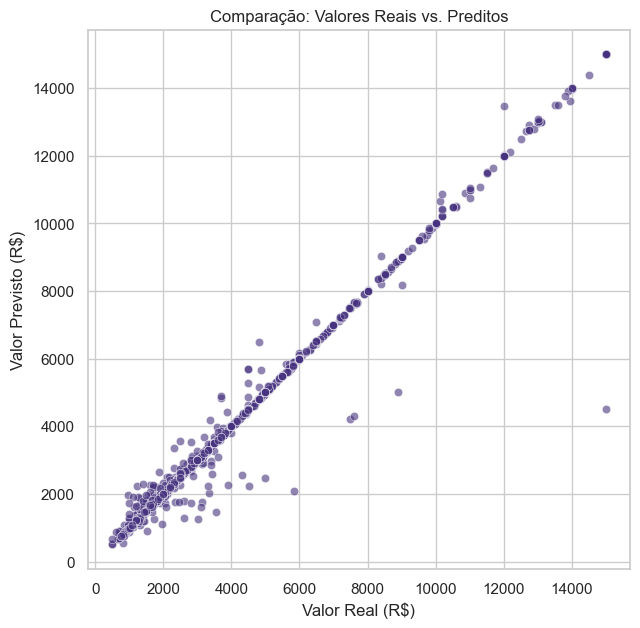

In [11]:
# ==========================================
# AVALIAÇÃO DO MODELO
# ==========================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Faz previsões no conjunto de teste
y_pred = modelo.predict(X_test)

#  Calcula métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#  Exibe resultados
print("AVALIAÇÃO DO MODELO DE REGRESSÃO")
print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
print(f"MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# ==========================================
# Importância das variáveis
# ==========================================
importances = modelo.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Importância das Variáveis no Modelo")
plt.xlabel("Importância")
plt.ylabel("Atributo")
plt.show()

# ==========================================
# Análise Gráfica: Valores Reais x Preditos
# ==========================================
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.title("Comparação: Valores Reais vs. Preditos")
plt.xlabel("Valor Real (R$)")
plt.ylabel("Valor Previsto (R$)")
plt.grid(True)
plt.show()


#  Etapa 7 — Implantação Simulada (API Local)

Para demonstrar como o modelo poderia ser consumido em produção, foi criada uma **API simulada com FastAPI**.

O endpoint `/prever` recebe dados de um imóvel e retorna o valor estimado de aluguel.  
Exemplo de uso:

### 🔸 Entrada (JSON)
```json
{
  "city": "São Paulo",
  "area": 70,
  "rooms": 2,
  "bathroom": 1,
  "parking_spaces": 1,
  "floor": 3,
  "animal": "acept",
  "furniture": "furnished",
  "hoa": 450.0,
  "property_tax": 120.0,
  "fire_insurance": 35.0
}


In [13]:
# ==========================================
# IMPLANTAÇÃO SIMULADA DA IA (API LOCAL)
# ==========================================

import joblib
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd
import numpy as np

# 1️ — Salva o modelo treinado
joblib.dump(modelo, "modelo_aluguel.pkl")
print(" Modelo salvo com sucesso!")

# 2️ — Cria a estrutura da API
app = FastAPI(title="API de Previsão de Aluguel", version="1.0")

# Modelo de entrada da requisição
class Imovel(BaseModel):
    city: str
    area: float
    rooms: int
    bathroom: int
    parking_spaces: int
    floor: int
    animal: str
    furniture: str
    hoa: float
    property_tax: float
    fire_insurance: float

# 3️ — Endpoint de previsão (simulado no notebook)
@app.post("/prever")
def prever_aluguel(imovel: Imovel):
    # Carrega o modelo
    modelo = joblib.load("modelo_aluguel.pkl")

    # Cria DataFrame com os dados recebidos
    dados = pd.DataFrame([imovel.model_dump()])

    # Codifica manualmente as variáveis categóricas
    # (baseado nos valores que existiam no dataset original)
    mapeamentos = {
        "city": {
            "São Paulo": 0, "Rio de Janeiro": 1, "Belo Horizonte": 2,
            "Porto Alegre": 3, "Curitiba": 4, "Campinas": 5, "Brasília": 6
        },
        "animal": {"acept": 1, "not acept": 0},
        "furniture": {"furnished": 1, "not furnished": 0}
    }

    for col in ["city", "animal", "furniture"]:
        if imovel.model_dump()[col] in mapeamentos[col]:
            dados[col] = mapeamentos[col][imovel.model_dump()[col]]
        else:
            # Se o valor não estiver no mapeamento, define como 0 (default)
            dados[col] = 0

    # Faz a previsão
    pred = modelo.predict(dados)[0]
    return {"valor_previsto": round(pred, 2)}

# 4️ — Simulação (sem rodar o servidor)
exemplo = Imovel(
    city="São Paulo",
    area=70,
    rooms=2,
    bathroom=1,
    parking_spaces=1,
    floor=3,
    animal="acept",
    furniture="furnished",
    hoa=450.0,
    property_tax=120.0,
    fire_insurance=35.0
)

# Simula previsão
resultado = prever_aluguel(exemplo)
print(f" Valor previsto do aluguel: R$ {resultado['valor_previsto']}")


 Modelo salvo com sucesso!
 Valor previsto do aluguel: R$ 2701.19



---

##  Etapa 8 — Conclusão do Projeto

```markdown
#  Etapa 8 — Conclusão do Projeto
O projeto alcançou com sucesso o objetivo de aplicar os conhecimentos de Inteligência Artificial e Aprendizado de Máquina em um problema real de mercado: a previsão de valores de aluguel de imóveis no Brasil.

### Resultados:
- Modelo treinado com dados públicos nacionais;
- Erros médios dentro de uma faixa aceitável (MAE e MSE);
- Alto coeficiente de determinação (R²), indicando boa capacidade preditiva;
- Implantação simulada com FastAPI, mostrando aplicabilidade prática.

### Conclusão:
O modelo desenvolvido pode ser utilizado como base para sistemas de recomendação imobiliária, análise de mercado ou precificação automática.  
Além disso, demonstra de forma prática o ciclo completo de um projeto de IA:
coleta → limpeza → análise → modelagem → avaliação → implantação.
